# Automated Feature Engineering

In this notebook, we will try our hand at automated feature engineering with the retail entity set. The objective is to predict whether or not a customer will spend more than \$500 in the next 30 days.

## Roadmap 

1. Format Data into an entityset
2. Develop a prediction problem
    * Create a dataframe of labels and cutoff times
    * Each customer can appear multiple times as a different label
3. Run deep feature sythesis on the entity to make features
    * Use the cutoff times to make features using valid data for each labels
4. Use the features to train a machine learning model
5. Tune deep feature synthesis 
6. Use random search for hyperparamter tuning the model

This problem is a great display of featuretools because it is time-based and can be broken down into different tables. Doing this problem by hand is nearly impossible to keep track of all the different cutoff times and valid data.

In [175]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import featuretools as ft

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer, MinMaxScaler

### Load in Raw Data

The raw data is a collection of purchases from an online retailer collected in 2011. Each row in the original data represents one product that was purchased.
We'll load in the data from an s3 bucket, convert the price in Pounds to dollars (based on the exchange rate on May 31, 2011) and create a column representing the total of the purchase. 

In [176]:
csv_s3 = "s3://featurelabs-static/online-retail-logs.csv"
data = pd.read_csv(csv_s3, parse_dates=["order_date"])
# Convert to dollars
data['price'] = data['price'] * 1.65
data['total'] = data['price'] * data['quantity']

# Restrict data to 2011
data = data[data['order_date'].dt.year == 2011]

data.head()

,order_id,product_id,description,quantity,order_date,price,customer_id,country,total
42481,539993,22386,JUMBO BAG PINK POLKADOT,10,2011-01-04 10:00:00,3.2175,13313.0,United Kingdom,32.175
42482,539993,21499,BLUE POLKADOT WRAP,25,2011-01-04 10:00:00,0.6930,13313.0,United Kingdom,17.325
42483,539993,21498,RED RETROSPOT WRAP,25,2011-01-04 10:00:00,0.6930,13313.0,United Kingdom,17.325
42484,539993,22379,RECYCLING BAG RETROSPOT,5,2011-01-04 10:00:00,3.4650,13313.0,United Kingdom,17.325
42485,539993,20718,RED RETROSPOT SHOPPER BAG,10,2011-01-04 10:00:00,2.0625,13313.0,United Kingdom,20.625


There are a few issues we need to address with the data. First, we'll drop the duplicated rows, then we'll drop any rows that contain a `nan`. Finally, we can add a `Boolean` column indicating whether or not an order is a cancellation.

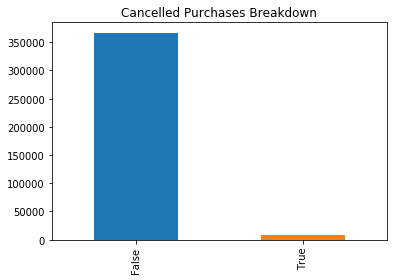

In [177]:
# drop the duplicates
data = data.drop_duplicates()

# drop rows with null customer id
data = data.dropna(axis=0)

data['cancelled'] = data['order_id'].str.startswith('C')
data['cancelled'].value_counts().plot.bar();
plt.title('Cancelled Purchases Breakdown');

All of the cancelled orders have negative quantities which mean that they cancel out with the corresponding purchase. 

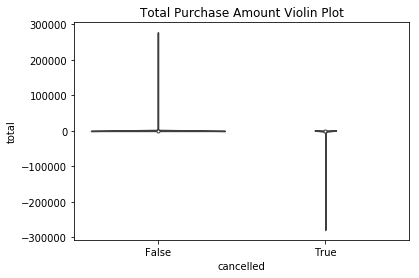

In [178]:
sns.violinplot(x = 'cancelled', y = 'total', data = data);
plt.title("Total Purchase Amount Violin Plot");

Now we can go ahead and create an `EntitySet`. Initially we'll add the entire `data` as an `entity` to the set.

In [179]:
es = ft.EntitySet(id="Online Retail Logs")

# Add the entire data table as an entity
es.entity_from_dataframe("order_products",
                         dataframe=data,
                         index="order_product_id",
                         time_index = 'order_date',
                         variable_types={'description': ft.variable_types.Text})

2018-07-29 10:58:11,783 featuretools.entityset - WARNING    index order_product_id not found in dataframe, creating new integer column


Entityset: Online Retail Logs
  Entities:
    order_products [Rows: 375250, Columns: 11]
  Relationships:
    No relationships

In order to create new tables out of the original table, we can normalize this `entity`. This creates new tables by creating a unique row for every variable that we pass in, such as the customer or the product.

In [180]:
# create a new "products" entity
es.normalize_entity(new_entity_id="products",
                    base_entity_id="order_products",
                    index="product_id",
                    additional_variables=["description"])

es['products'].df.head()

,product_id,description,first_order_products_time
20682,20682,RED RETROSPOT CHILDRENS UMBRELLA,2011-01-04 10:00:00
20718,20718,RED RETROSPOT SHOPPER BAG,2011-01-04 10:00:00
21498,21498,RED RETROSPOT WRAP,2011-01-04 10:00:00
21499,21499,BLUE POLKADOT WRAP,2011-01-04 10:00:00
22302,22302,COFFEE MUG PEARS DESIGN,2011-01-04 10:00:00


What this has done is created a new table where every product has one row (it is normalized by the product). The `first_order_products_time` represents the first time the `product` appears in the data. We can use this table to create new features and this table is a parent of the `order_products` table with the linknage through the `product_id`.

We'll repeat the process to create tables for both the `customers` and the `orders`. Using `normalize_entity` automatically creates the relationships and time index so we don't have to do that ourselves.

In [181]:
# create a new "orders" entity
es.normalize_entity(new_entity_id="orders",
                    base_entity_id="order_products",
                    index="order_id",
                    additional_variables=[
                        "customer_id", "country", 'cancelled'])

# create a new "customers" entity based on the orders entity
es.normalize_entity(new_entity_id="customers",
                    base_entity_id="orders",
                    index="customer_id")

es

Entityset: Online Retail Logs
  Entities:
    order_products [Rows: 375250, Columns: 7]
    products [Rows: 3612, Columns: 3]
    orders [Rows: 20482, Columns: 5]
    customers [Rows: 4244, Columns: 2]
  Relationships:
    order_products.product_id -> products.product_id
    order_products.order_id -> orders.order_id
    orders.customer_id -> customers.customer_id

The next step is to define the prediction problem.

# Prediction Problem

The goal of machine learning is to predict some quantity or a label. In this case, we will make it our aim to predict whether or not a customer will spend more than \$500 in the next 30 days. However, instead of picking one point in the data and making predictions for the next 30 days, we can select multiple points in the data and ask will the customer spend \$500 over the next month. We therefore get multiple labelled training examples for each customer.

The function below takes in a start date and an end date (which we can set to 30 days apart) and generates a dataframe of the labels, which is the amount the customter spent in the period. For customers who appear in the data prior to the start date but then do have a purchase in between the start and end date, we want to set their total to 0.

In [182]:
def make_retail_cutoffs_total(start_date, end_date, threshold = 500):
    
    # Find customers who exist before start date
    customer_pool = data[data['order_date'] < start_date]['customer_id'].unique()
    tmp = pd.DataFrame({'customer_id': customer_pool})

    # For customers in the customer pool, find their sum between the start and end date
    totals = data[data['customer_id'].isin(customer_pool) & 
        (data['order_date'] > start_date) & 
        (data['order_date']<end_date)
    ].groupby('customer_id')['total'].sum().reset_index()
    
    # Merge with all the customer ids to record all customers who existed before start date
    totals = totals.merge(tmp, on = 'customer_id', how = 'right')

    # Set the total for any customer who did not have a purchase in the timeframe equal to 0
    totals['total'] = totals['total'].fillna(0)
    
    # Label is based on the threshold
    totals['label'] = (totals['total'] > threshold).astype(int)
        
    # The cutoff time is the start date
    totals['cutoff_time'] = pd.to_datetime(start_date)
    totals = totals[['customer_id', 'cutoff_time', 'total', 'label']]
    
    return totals

In [183]:
may_spending = make_retail_cutoffs_total(pd.datetime(2011, 5, 1), pd.datetime(2011, 6, 1))
may_spending.head()

,customer_id,cutoff_time,total,label
0,12372.0,2011-05-01,850.9050,1
1,12395.0,2011-05-01,547.4535,1
2,12399.0,2011-05-01,793.4850,1
3,12414.0,2011-05-01,273.6525,0
4,12415.0,2011-05-01,20940.4140,1


Because we set the total to zero for any customers who did not have a purchase, the `total` comes out to be very imbalanced. However, we cannot only count the customers who did have a purchase in the time frame because that would be essentially cheating with the data!

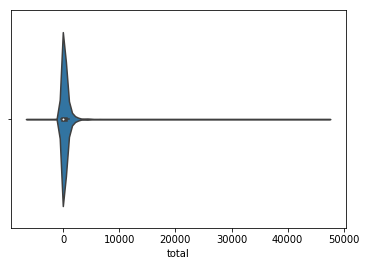

In [184]:
sns.violinplot(may_spending['total']);

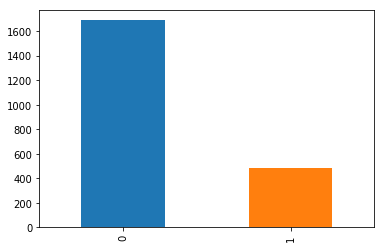

In [185]:
may_spending['label'].value_counts().plot.bar();

We also have negative spending indicating customers who only had a cancelled order in the month (or at least more cancellations than purchases). These aren't necessarily an issue because we will frame this as a binary classification problem. We can now calculate the labels for 7 more months using the threshold of \$500. At the end we will concatenate all of these into one label dataframe.

In [186]:
june_spending = make_retail_cutoffs_total('2011-06-01', '2011-07-01', 500)
july_spending = make_retail_cutoffs_total('2011-07-01', '2011-08-01', 500)
august_spending = make_retail_cutoffs_total('2011-08-01', '2011-09-01', 500)
september_spending = make_retail_cutoffs_total('2011-09-01', '2011-10-01', 500)
october_spending = make_retail_cutoffs_total('2011-10-01', '2011-11-01', 500)
november_spending = make_retail_cutoffs_total('2011-11-01', '2011-12-01', 500)
december_spending = make_retail_cutoffs_total('2011-12-01', '2012-01-01', 500)

In [187]:
labels = pd.concat([may_spending, june_spending, july_spending, august_spending, 
                    september_spending, october_spending, november_spending, december_spending], axis = 0)
labels.describe()

,customer_id,total,label
count,25039.000000,25039.000000,25039.000000
mean,15274.220017,324.757930,0.168857
std,1719.499912,1922.739028,0.374633
min,12346.000000,-5916.636000,0.000000
25%,13784.000000,0.000000,0.000000
50%,15241.000000,0.000000,0.000000
75%,16755.000000,184.395750,0.000000
max,18287.000000,115906.725000,1.000000


That gives us over 25,000 labels to work with. Each label represents one customer-month with ~16% of the labels as True. We can plot the total spending by month. 

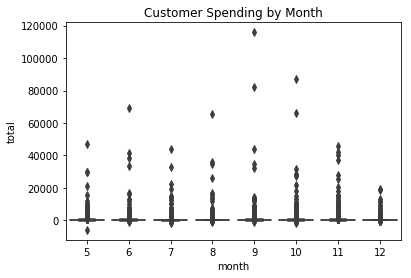

In [188]:
labels['month'] = labels['cutoff_time'].dt.month
sns.boxplot(x = 'month', y = 'total', data = labels);
plt.title('Customer Spending by Month');

In [189]:
def ecdf(data):
    x = np.sort(data)
    y = np.arange(1, len(x) + 1) / len(x)
    return x, y

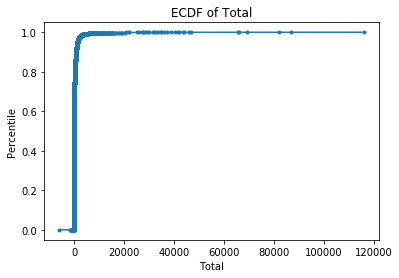

In [190]:
x, y = ecdf(labels['total'])
plt.plot(x, y, marker = '.')
plt.xlabel('Total'); plt.ylabel('Percentile'); plt.title('ECDF of Total');

The empirical cumulative distribution function plot shows a clear imbalance in the total spending with most customers around 0, but a few large spenders. There are also a few customers that had more cancellations (which show up as negative) than purchases in the time frame. 

In [196]:
labels.loc[labels['customer_id'] == 12347].drop(columns = 'month')

,customer_id,cutoff_time,total,label
1111,12347.0,2011-05-01,0.0000,0
0,12347.0,2011-06-01,631.1580,1
1165,12347.0,2011-07-01,0.0000,0
0,12347.0,2011-08-01,965.1015,1
1357,12347.0,2011-09-01,0.0000,0
0,12347.0,2011-10-01,2135.6280,1
1658,12347.0,2011-11-01,0.0000,0
0,12347.0,2011-12-01,370.9530,0


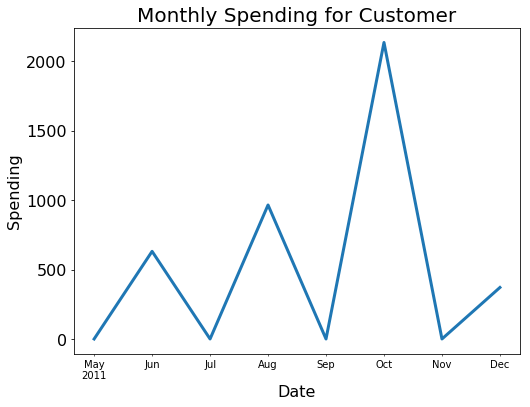

In [203]:
labels.loc[labels['customer_id'] == 12347].set_index('cutoff_time')['total'].plot(figsize = (8, 6), linewidth = 3)
plt.xlabel('Date', size = 16); 
plt.ylabel('Spending', size = 16); 
plt.title('Monthly Spending for Customer', size = 20);
plt.xticks(size = 16); plt.yticks(size = 16);

# Deep Feature Synthesis 

Using the labels and the entityset, we can now directly use deep feature synthesis. The following function will generate 100s of features for our problem, with one row for each customer and the columns holding the features.

In [206]:
feature_matrix, feature_names = ft.dfs(entityset=es, target_entity='customers',
                                       cutoff_time = labels, verbose = 2,
                                       cutoff_time_in_index = True,
                                       chunk_size = len(labels), n_jobs = -1)

feature_matrix.head()

Built 143 features
EntitySet scattered to workers in 6.309 seconds
Elapsed: 03:01 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 252/252 chunks


COUNT(orders)  PERCENT_TRUE(orders.cancelled)  \
customer_id time                                                        
12346.0     2011-05-01              2                             0.5   
            2011-05-01              2                             0.5   
            2011-05-01              2                             0.5   
            2011-05-01              2                             0.5   
            2011-05-01              2                             0.5   

                        NUM_UNIQUE(orders.country) MODE(orders.country)  \
customer_id time                                                          
12346.0     2011-05-01                           1       United Kingdom   
            2011-05-01                           1       United Kingdom   
            2011-05-01                           1       United Kingdom   
            2011-05-01                           1       United Kingdom   
            2011-05-01                           1       United Kingdom   

                        SUM(order_products.quantity)  \
customer_id time                                       
12346.0     2011-05-01                             0   
            2011-05-01                             0   
            2011-05-01                             0   
            2011-05-01                             0   
            2011-05-01                             0   

                        SUM(order_products.price)  SUM(order_products.total)  \
customer_id time                                                               
12346.0     2011-05-01                      3.432                        0.0   
            2011-05-01                      3.432                        0.0   
            2011-05-01                      3.432                        0.0   
            2011-05-01                      3.432                        0.0   
            2011-05-01                      3.432                        0.0   

                        STD(order_products.quantity)  \
customer_id time                                       
12346.0     2011-05-01                       74215.0   
            2011-05-01                       74215.0   
            2011-05-01                       74215.0   
            2011-05-01                       74215.0   
            2011-05-01                       74215.0   

                        STD(order_products.price)  STD(order_products.total)  \
customer_id time                                                               
12346.0     2011-05-01                        0.0                  127352.94   
            2011-05-01                        0.0                  127352.94   
            2011-05-01                        0.0                  127352.94   
            2011-05-01                        0.0                  127352.94   
            2011-05-01                        0.0                  127352.94   

                        ...    \
customer_id time        ...     
12346.0     2011-05-01  ...     
            2011-05-01  ...     
            2011-05-01  ...     
            2011-05-01  ...     
            2011-05-01  ...     

                        NUM_UNIQUE(orders.MONTH(first_order_products_time))  \
customer_id time                                                              
12346.0     2011-05-01                                                  1     
            2011-05-01                                                  1     
            2011-05-01                                                  1     
            2011-05-01                                                  1     
            2011-05-01                                                  1     

                        NUM_UNIQUE(orders.WEEKDAY(first_order_products_time))  \
customer_id time                                                                
12346.0     2011-05-01                                                  1       
            2011-05-01                           

In [216]:
feature_matrix.index.names = ['customer_id', 'cutoff_time']

In [220]:
feature_matrix = feature_matrix.drop_duplicates()
feature_matrix.loc[12347, :].sample(10, axis = 1)

,STD(orders.MIN(order_products.total)),WEEKDAY(first_orders_time),STD(orders.MEAN(order_products.price)),SUM(orders.STD(order_products.price)),MAX(orders.MEAN(order_products.total)),MIN(orders.NUM_UNIQUE(order_products.product_id)),STD(orders.SUM(order_products.quantity)),MAX(order_products.price),MODE(orders.YEAR(first_order_products_time)),SKEW(order_products.quantity)
cutoff_time,,,,,,,,,,
2011-05-01,0.792000,2,0.059658,8.115698,43.742188,24,84.000000,21.0375,2011,6.496496
2011-06-01,0.792000,2,0.059658,8.115698,43.742188,24,84.000000,21.0375,2011,6.496496
2011-07-01,3.697178,2,0.330009,11.604839,43.742188,18,117.735108,21.0375,2011,7.344654
2011-08-01,3.697178,2,0.330009,11.604839,43.742188,18,117.735108,21.0375,2011,7.344654
2011-09-01,3.358743,2,0.405529,16.198629,43.868250,18,104.640754,21.0375,2011,8.044939
2011-10-01,3.358743,2,0.405529,16.198629,43.868250,18,104.640754,21.0375,2011,8.044939
2011-11-01,3.070923,2,0.393313,19.987320,45.438894,18,171.156770,21.0375,2011,8.985468
2011-12-01,3.070923,2,0.393313,19.987320,45.438894,18,171.156770,21.0375,2011,8.985468


In [204]:
feature_matrix = feature_matrix.drop(columns = ['total', 'label', 'month'])
feature_matrix.shape

KeyError: "labels ['total' 'label' 'month'] not contained in axis"

## Preliminary modeling

At this point the matrix is ready to for modeling. We will want to one-hot encode the columns first and then we can get to machine learning. For splitting into a training and testing set, we'll make the test set one month of the data and then the training data will be all the months before that date.

## Metrics

We can measure metrics in terms of:

* Precision: the percentage of customers predicted to spend more than \$500 that actually did
* Recall: the percentage of customers that actually spent more than \$500 that were predicted correctly
* F1 score: the harmonic mean of precision and recall
* Receiver Operating Characterisic Area Under the Curve (ROC AUC): a 0 to 1 measure (with 1 being optimal) that measures the performance of a model across a range of thresholds

In [85]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score

In [81]:
feature_matrix_enc = pd.get_dummies(feature_matrix)
print('Total features after one-hot encoding: ', feature_matrix_enc.shape[1])

Total features after one-hot encoding:  2669


In [84]:
feature_matrix_enc.reset_index(inplace = True)
feature_matrix_enc.head()

,customer_id,time,COUNT(orders),PERCENT_TRUE(orders.cancelled),NUM_UNIQUE(orders.country),SUM(order_products.quantity),SUM(order_products.price),SUM(order_products.total),STD(order_products.quantity),STD(order_products.price),...,MODE(orders.MODE(order_products.product_id))_85172,MODE(orders.MODE(order_products.product_id))_85173,MODE(orders.MODE(order_products.product_id))_85194L,MODE(orders.MODE(order_products.product_id))_85202,MODE(orders.MODE(order_products.product_id))_85203,MODE(orders.MODE(order_products.product_id))_BANK CHARGES,MODE(orders.MODE(order_products.product_id))_CRUK,MODE(orders.MODE(order_products.product_id))_D,MODE(orders.MODE(order_products.product_id))_M,MODE(orders.MODE(order_products.product_id))_POST
0,12346.0,2011-05-01,2,0.500,1,0,3.4320,0.000,74215.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
1,12347.0,2011-05-01,2,0.000,1,798,223.5090,1834.206,32.080921,4.049262,...,0,0,0,0,0,0,0,0,0,0
2,12348.0,2011-05-01,2,0.000,1,870,142.9065,980.826,57.138515,24.996439,...,0,0,0,0,0,0,0,0,0,0
3,12350.0,2011-05-01,1,0.000,1,197,107.7450,551.760,4.215641,14.942464,...,0,0,0,0,0,0,0,0,0,0
4,12352.0,2011-05-01,8,0.375,1,188,3135.1155,991.947,6.960703,157.369454,...,0,0,0,0,0,0,0,0,0,0


### Model

For a model, we will use the `RandomForestClassifier` as implemented in Scikit-Learn. We'll keep most of the hyperparameters at the default values but increase the number of trees to 1000. This is not an optimized model but should allow us to tell whether or not our solution is better than a baseline estimate.

In [86]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators = 1000, random_state = 50,
                               n_jobs = -1)

In [149]:
def predict_month(month, feature_matrix, return_probs = False):
    
    test_labels = labels.loc[labels['month'] == month, ['customer_id', 'label']]
    train_labels = labels.loc[labels['month'] < month, ['customer_id', 'label']]
    
    # Features
    X_train = feature_matrix[feature_matrix['time'].dt.month < month].drop(columns = ['customer_id', 'time'])
    X_test = feature_matrix[feature_matrix['time'].dt.month == month].drop(columns = ['customer_id', 'time'])
    feature_names = list(X_train.columns)
    
    pipeline = Pipeline([('imputer', Imputer(strategy = 'median')), 
                      ('scaler', MinMaxScaler())])

    # Fit and transform training data
    X_train = pipeline.fit_transform(X_train)
    X_test = pipeline.transform(X_test)
    
    # Labels
    y_train = np.array(train_labels['label']).reshape((-1, ))
    y_test = np.array(test_labels['label']).reshape((-1, ))
    
    
    
    # Train 
    model.fit(X_train, y_train)
    
    # Make predictions
    predictions = model.predict(X_test)
    probs = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    p = precision_score(y_test, predictions)
    r = recall_score(y_test, predictions)
    f = f1_score(y_test, predictions)
    auc = roc_auc_score(y_test, probs)
    
    print(f'Precision: {round(p, 5)}')
    print(f'Recall: {round(r, 5)}')
    print(f'F1 Score: {round(f, 5)}')
    print(f'ROC AUC: {round(auc, 5)}')
    
    # Feature importances
    fi = pd.DataFrame({'feature': feature_names, 'importance': model.feature_importances_})
    
    if return_probs:
        return fi, probs
    
    return fi
    

In [90]:
june_fi = predict_month(6, feature_matrix_enc)

Precision: 0.51842
Recall: 0.46244
F1 Score: 0.48883
ROC AUC: 0.78358


We can plot the feature importances using a utility function. These should allow us to see what the model considers useful information for predicting spending.

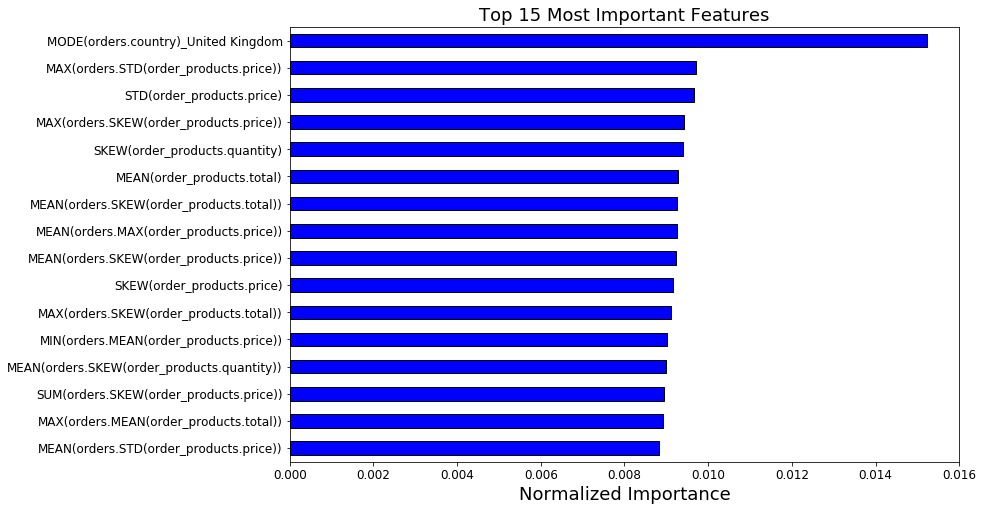

In [91]:
norm_june_fi = plot_feature_importances(june_fi)

## Comparison to Baseline

Now let's look at how these numbers compare to the baseline. If we use the amount the customer spent in the past month, can we use that to predict how much they will spend in the next month? We can try this for July 2011.

In [94]:
july_labels = labels[labels['month'] == 7]
june_labels = labels[labels['month'] == 6]

july_labels = july_labels.rename(columns = {'total': 'july_total'})
june_labels = june_labels.rename(columns = {'total': 'june_total'})

july_labels = july_labels.merge(june_labels[['customer_id', 'june_total']], on = 'customer_id', how = 'left')
july_labels['june_total'] = july_labels['june_total'].fillna(0)
july_labels['prediction'] = (july_labels['june_total'] > 500).astype(int)
july_labels.head()

,customer_id,cutoff_time,july_total,label,month,june_total,prediction
0,12362.0,2011-07-01,501.2040,1,7,0.0,0
1,12379.0,2011-07-01,-3.2175,0,7,0.0,0
2,12388.0,2011-07-01,1488.4485,1,7,0.0,0
3,12407.0,2011-07-01,1503.8100,1,7,0.0,0
4,12412.0,2011-07-01,620.7960,1,7,0.0,0


In [96]:
print('Precision: {:.5f}.'.format(precision_score(july_labels['label'], july_labels['prediction'])))
print('Recall: {:.5f}.'.format(recall_score(july_labels['label'], july_labels['prediction'])))
print('F1 Score: {:.5f}.'.format(f1_score(july_labels['label'], july_labels['prediction'])))
print('ROC AUC Score: {:.5f}.'.format(roc_auc_score(july_labels['label'], july_labels['prediction'])))

Precision: 0.41784.
Recall: 0.39644.
F1 Score: 0.40686.
ROC AUC Score: 0.64438.


In [106]:
july_fi = predict_month(7, feature_matrix_enc)

Precision: 0.51689
Recall: 0.34076
F1 Score: 0.41074
ROC AUC: 0.81947


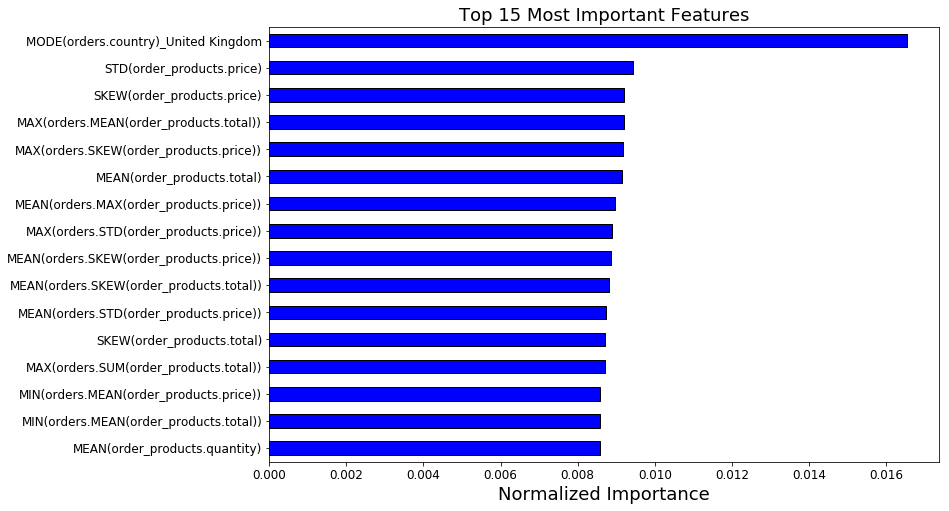

In [107]:
norm_july_fi = plot_feature_importances(july_fi)

In [108]:
def informed_baseline(month_number):
    month = labels[labels['month'] == month_number]
    previous_month = labels[labels['month'] == (month_number - 1)]
    
    previous_month = previous_month.rename(columns = {'total': 'previous_total'})

    month = month.merge(previous_month[['customer_id', 'previous_total']], on = 'customer_id', how = 'left')
    month['previous_total'] = month['previous_total'].fillna(0)
    month['prediction'] = (month['previous_total'] > 500).astype(int)
    
    print('Precision: {:.5f}.'.format(precision_score(month['label'], month['prediction'])))
    print('Recall: {:.5f}.'.format(recall_score(month['label'], month['prediction'])))
    print('F1 Score: {:.5f}.'.format(f1_score(month['label'], month['prediction'])))
    print('ROC AUC Score: {:.5f}.'.format(roc_auc_score(month['label'], month['prediction'])))
    
    return month

In [99]:
december = informed_baseline(12)

Precision: 0.21606.
Recall: 0.57547.
F1 Score: 0.31416.
ROC AUC Score: 0.70215.


In [100]:
december_fi = predict_month(12)

Precision: 0.27073
Recall: 0.50314
F1 Score: 0.35204
ROC AUC: 0.86048


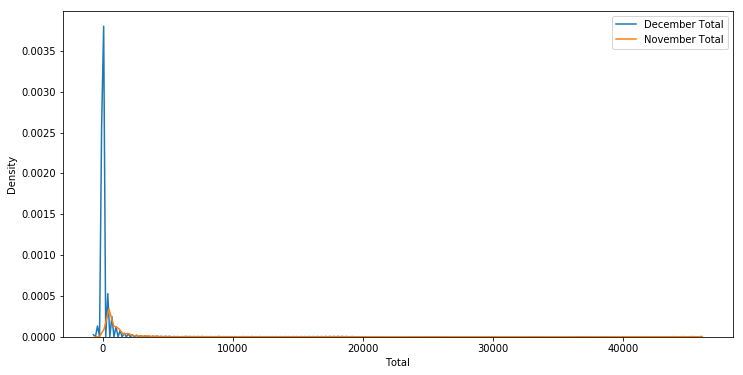

In [27]:
plt.figure(figsize = (12, 6))
sns.kdeplot(december['total'], label = 'December Total');
sns.kdeplot(december['previous_total'], label = 'November Total');
plt.legend(); plt.xlabel('Total'); plt.ylabel('Density');

From this analysis, we can conclude that machine learning delivers some value for the problem. Let's take a look at the feature importances for December.

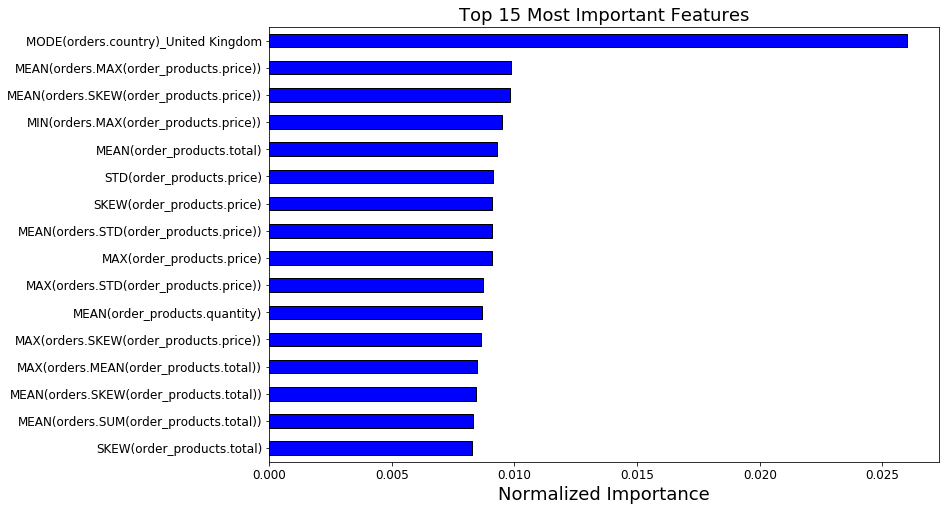

In [101]:
norm_december_fi = plot_feature_importances(december_fi)

It's interesting that the most important feature is whether the most common country for the order is the United Kingdom. This suggests there may a difference in order that come from the United Kingdom versus orders from other countries.

In [102]:
orders = es['orders'].df
order_products = es['order_products'].df
order_products = order_products.merge(orders[['order_id', 'country']], 
                                      on = 'order_id', how = 'left')

orders_by_country = order_products.groupby('country')['total'].agg(['sum', 'mean', 'count'])
orders_by_country.head()

,sum,mean,count
country,,,
Australia,224519.0805,183.430621,1224
Austria,16330.5120,41.659469,392
Bahrain,904.8600,53.227059,17
Belgium,64516.7325,32.683248,1974
Brazil,1886.9400,58.966875,32


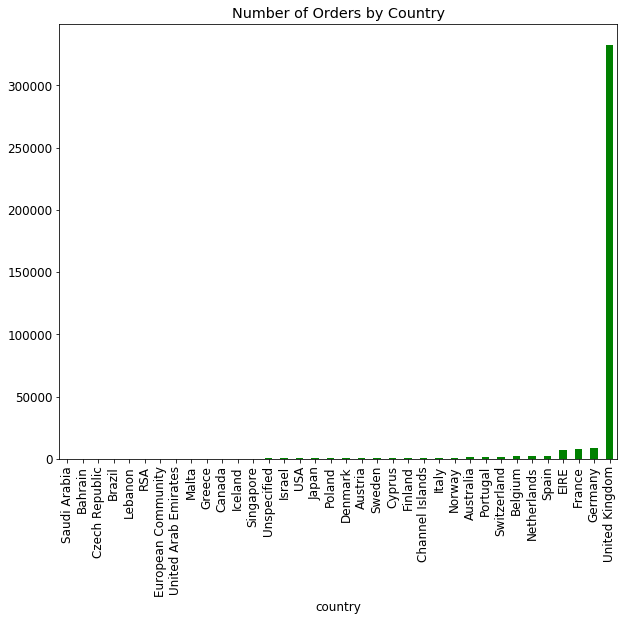

In [103]:
orders_by_country['count'].sort_values().plot.bar(color = 'green', 
                                    figsize = (10, 8));
plt.title('Number of Orders by Country');

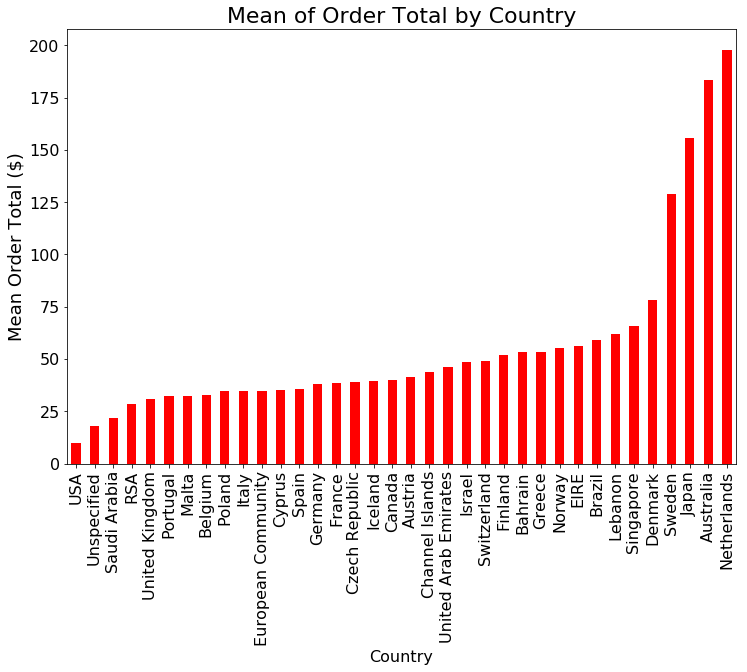

In [222]:
orders_by_country['mean'].sort_values().plot.bar(color = 'red', 
                                    figsize = (12, 8));
plt.title('Mean of Order Total by Country', size = 22);
plt.ylabel('Mean Order Total ($)', size = 18); plt.xlabel('Country', size = 16)
plt.xticks(size = 16); plt.yticks(size = 16);

Let's try some minor feature selection and see if the performance improves. The following call 
removes:

* One out of every pair of columns that have a perfect correlation (all values are equal)
* Any features with more than 80% missing values 
* Any features with only a single unique value
* One out of every pair of columns with a correlation greater than 0.9.

In [112]:
t = feature_matrix_enc['time']
feature_matrix_selected = feature_selection(feature_matrix_enc.drop(columns = ['time']),
                                                                    missing_threshold=80, correlation_threshold=0.9)
feature_matrix_selected['time'] = t

Original shape:  (25039, 2670)
230  non-unique valued columns.
0 missing columns with threshold: 80.
2 zero variance columns.
108 collinear columns removed with threshold: 0.9.
Total columns removed:  340
Shape after feature selection: (25039, 2330).


NameError: name 'evaluate_month' is not defined

In [113]:
december_fi = predict_month(12, feature_matrix_selected)

Precision: 0.28426
Recall: 0.5283
F1 Score: 0.36964
ROC AUC: 0.86234


Feature selection slightly improved the models performance compared to the original metrics (shown below):

    Precision: 0.27073
    Recall: 0.50314
    F1 Score: 0.35204
    ROC AUC: 0.86048

### Feature Selection Based on Feature Importances

Another method we can use for feature selection is to remove any features that have zero importance. In a decision tree based model, removing these features will have no effect on performance and is hence a safe option for feature selection.

In [115]:
zero_features = december_fi.loc[december_fi['importance'] == 0, 'feature']
print(f'{len(zero_features)} features with no importance.')

148 features with no importance.


In [116]:
feature_matrix_selected = feature_matrix_selected[[x for x in feature_matrix_selected if x not in zero_features]]
feature_matrix_selected.shape

(25039, 2331)

## Tuning Deep Feature Synthesis

We can specify different primitives to deep feature synthesis in order to generate different features. Let's try making a new feature matrix with specified primitives.

In [122]:
feature_matrix, feature_names = ft.dfs(entityset=es, target_entity='customers',
                                       agg_primitives = ['std', 'trend', 'max', 'min', 
                                                         'mean', 'skew', 'last', 'avg_time_between'],
                                       trans_primitives = ['cum_sum', 'cum_mean', 'day', 
                                                           'month', 'hour', 'weekend'],
                                       n_jobs = -1, chunk_size = len(labels), 
                                       cutoff_time = labels[['customer_id', 'cutoff_time']],
                                       verbose = 1)
feature_matrix.head()

Built 250 features
EntitySet scattered to workers in 2.329 seconds
Elapsed: 59:26 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 1/1 chunks


,LAST(orders.country),LAST(orders.cancelled),AVG_TIME_BETWEEN(orders.first_order_products_time),STD(order_products.quantity),STD(order_products.price),STD(order_products.total),"TREND(order_products.price, order_date)","TREND(order_products.quantity, order_date)","TREND(order_products.total, order_date)",MAX(order_products.quantity),...,CUM_MEAN(LAST(order_products.total) by LAST(order_products.product_id)),CUM_MEAN(LAST(order_products.price) by LAST(order_products.product_id)),DAY(LAST(orders.first_order_products_time)),DAY(LAST(order_products.order_date)),MONTH(LAST(orders.first_order_products_time)),MONTH(LAST(order_products.order_date)),HOUR(LAST(orders.first_order_products_time)),HOUR(LAST(order_products.order_date)),WEEKEND(LAST(orders.first_order_products_time)),WEEKEND(LAST(order_products.order_date))
customer_id,,,,,,,,,,,,,,,,,,,,,
12346.0,United Kingdom,True,960.0,74215.000000,0.000000,127352.940000,NaN,NaN,NaN,74215,...,-127352.94,1.7160,18,18,1,1,10,10,False,False
12347.0,Iceland,False,6120780.0,32.080921,4.049262,53.512381,0.000001,0.000091,0.000164,240,...,28.05,7.0125,7,7,4,4,10,10,False,False
12348.0,Finland,False,6048300.0,57.138515,24.996439,52.784090,0.000031,-0.000460,0.000581,144,...,66.00,66.0000,5,5,4,4,10,10,False,False
12350.0,Norway,False,NaN,4.215641,14.942464,11.646210,0.000000,0.000000,0.000000,24,...,41.58,3.4650,2,2,2,2,16,16,False,False
12352.0,Norway,False,421500.0,6.960703,157.369454,171.627342,-0.000948,-0.000081,-0.000464,12,...,24.75,2.0625,22,22,3,3,16,16,False,False


After building the new feature matrix, we need to one-hot encode it. We can also use feature selection because that improves performance.

In [135]:
feature_matrix_enc = pd.get_dummies(feature_matrix)

for col in feature_matrix_enc:
    if feature_matrix_enc[col].dtype == 'bool':
        feature_matrix_enc[col] = feature_matrix_enc[col].astype(np.uint8)

feature_matrix_selected = feature_selection(feature_matrix_enc)

Original shape:  (25039, 2379)
8  non-unique valued columns.
0 missing columns with threshold: 90.
0 zero variance columns.
108 collinear columns removed with threshold: 0.95.
Total columns removed:  116
Shape after feature selection: (25039, 2263).


In [151]:
feature_matrix_selected.reset_index(inplace = True)

# Add the time
feature_matrix_selected['time'] = list(labels['cutoff_time'])

june_fi = predict_month(6, feature_matrix_enc)

Precision: 0.54575
Recall: 0.39202
F1 Score: 0.45628
ROC AUC: 0.80508


The previous metrics for June were:

    Precision: 0.51842
    Recall: 0.46244
    F1 Score: 0.48883
    ROC AUC: 0.78358

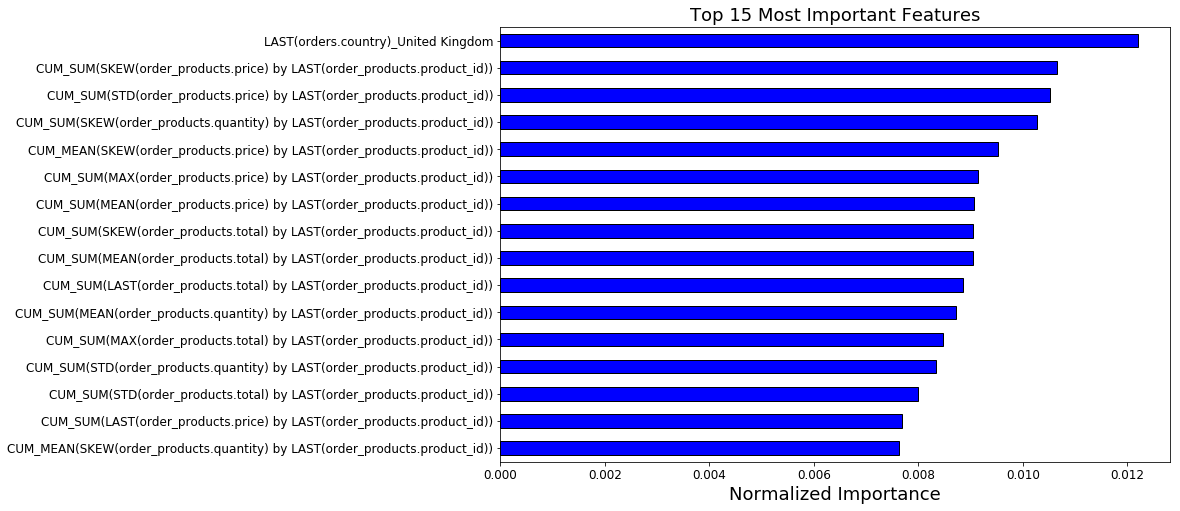

In [152]:
norm_june_fi = plot_feature_importances(june_fi)

In [153]:
december_fi = predict_month(12, feature_matrix_enc)

Precision: 0.30785
Recall: 0.46855
F1 Score: 0.37157
ROC AUC: 0.87213


In [154]:
_ = informed_baseline(12)

Precision: 0.21606.
Recall: 0.57547.
F1 Score: 0.31416.
ROC AUC Score: 0.70215.


The model with more features from Featuretools again significantly outperforms the baseline. To improve the precision, recall, and consequently the F1 score, we can tune the threshold of predictions made by the model.

In [169]:
from sklearn.metrics import precision_recall_curve

## Precision Recall Curve

We can use the precision recall curve to identify the ideal threshold for our model. For example, we might care more about identifying the customers likely to spend more 

Precision: 0.31158
Recall: 0.46541
F1 Score: 0.37327
ROC AUC: 0.87535


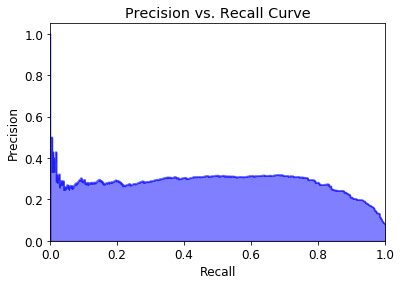

In [174]:
month = 12
# Find the probability
fi, probs = predict_month(month, feature_matrix_selected, 
                          return_probs = True)

precision, recall, t = precision_recall_curve(labels.loc[labels['cutoff_time'].dt.month == month, 'label'], 
                                              probs)

plt.step(recall, precision, color='b', alpha=0.5,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.5,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title("Precision vs. Recall Curve"); plt.show();

In [ ]:
plt.text(precision[::10], recall[::10], s = )

In [170]:
def precision_recall(month):
    "Show the precision vs recall curve for a month"
    
    # Find the probability
    fi, probs = predict_month(month, feature_matrix_selected, 
                              return_probs = True)
    
    precision, recall, t = precision_recall_curve(labels.loc[labels['cutoff_time'].dt.month == month, 'label'], 
                                                  probs)
    
    plt.step(recall, precision, color='b', alpha=0.5,
             where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.5,
                     color='b')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title("Precision vs. Recall Curve"); plt.show();

Precision: 0.31158
Recall: 0.46541
F1 Score: 0.37327
ROC AUC: 0.87535


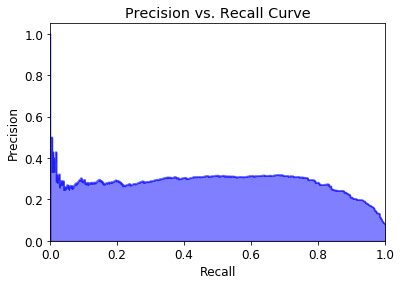

In [171]:
precision_recall(12)


We can use this plot to select an appropriate threshold. For example, we may care more about identifying customers who will spend more than \$500 than about false positive so we choose a threshold that results in high recall but low precision. Conversely, we may want to limit false positives even if that means missing some potential high-spending customers so we would try for a higher level of precision.

In [172]:
t

array([0.01176964, 0.01195033, 0.012     , ..., 0.9934716 , 0.999     ,
       0.99927632])